---
# Install the required packages

If needed install the following packages:

In [1]:
# !pip install datasets transformers imbalanced-learn evaluate

---
# Imports

In [1]:
from datasets import load_dataset

# Write your code here. Add as many boxes as you need.

D:\anaconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
# Laboratory Exercise - Run Mode (8 points)

## Introduction

This laboratory assignment's primary objective is to fine-tune a pre-trained language model for detection of toxic sentences (binary classification). 

The dataset contains two attributes: 
- `text`: The sentence which needs to be classified in to toxic/non-toxic
- `label`: 0/1 indicator if the given sentence is toxic

**Note: You are required to perform this laboratory assignment on your local machine.**

# Read the data

The dataset reading is given. Just run the following 2 cells.

**DO NOT MODIFY IT! Just analyse how the data reading was performed, as in the future this part won't be given.**

In [2]:
dataset = load_dataset(
    'csv', 
    data_files={'train': 'data/train.tsv', 'test': 'data/test.tsv'},
    delimiter='\t'
)

Generating train split: 1000 examples [00:00, 50032.85 examples/s]
Generating test split: 3132 examples [00:00, 120979.51 examples/s]


**The prediction target column MUST be named 'label' in the dataset !**

See the dataset structure:

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3132
    })
})

In [4]:
df = dataset["train"].to_pandas()
df["label"].unique()

array([1, 0])

In [5]:
df

,text,label
0,both sides need to calm the fuck down or we ar...,1
1,and what shit hole country might you be from,1
2,You make that with impunity and you may get so...,0
3,"Get more grip, please",0
4,anyone who doesn 't kiss the ayatollah must be...,0
...,...,...
995,"Hold your cheeks, thrusting at once, crying out",0
996,Who asks why muslims hate us,0
997,"i don 't care if i get downvoted , but Amanda ...",0
998,the fuck is wrong with the catholic clergy ?,1


---
# Natural Language Processing

## Generate the Tokenizer and Data Collator

For the purposes of this lab you will be using `DistilBertTokenizer` and `DataCollatorWithPadding`.

In [6]:
# Write your code here. Add as many boxes as you need.
from transformers import AutoTokenizer
checkpoint = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [11]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Tokenize the dataset

For the purposes of lowering the amount of computing set the `max_length` parameter to 15.

In [7]:
# Write your code here. Add as many boxes as you need.
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [8]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|███████████████████████████████████████████████████████████████| 3132/3132 [00:00<00:00, 10751.98 examples/s]


## Define the model

The required model for this lab is the `DistilBertForSequenceClassification`.

In [9]:
# Write your code here. Add as many boxes as you need.
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define the training arguments

For lowering the compute time I recommend using the following parameters:
- per_device_train_batch_size=128
- per_device_eval_batch_size=128
- **num_train_epochs=1**

In [10]:
# Write your code here. Add as many boxes as you need.
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=128,  # batch size for training
    per_device_eval_batch_size=128,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1,
    # report_to="none",
)

## Load the metrics

Load the best metric for the this specific problem.

In [12]:
# Write your code here. Add as many boxes as you need.
import evaluate
import numpy as np

metric = evaluate.load("f1")

### Define the function to compute the metrics

In [13]:
# Write your code here. Add as many boxes as you need.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

## Generate the Trainer object

In [14]:
# Write your code here. Add as many boxes as you need.
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

## Train the model

Use the trainer to train the model.

In [15]:
# Write your code here. Add as many boxes as you need.
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.558151,0.805884


TrainOutput(global_step=8, training_loss=0.6418391466140747, metrics={'train_runtime': 457.3368, 'train_samples_per_second': 2.187, 'train_steps_per_second': 0.017, 'total_flos': 13032219460800.0, 'train_loss': 0.6418391466140747, 'epoch': 1.0})

In [16]:
trainer.evaluate()

{'eval_loss': 0.5581506490707397,
 'eval_f1': 0.8058836057668813,
 'eval_runtime': 250.9338,
 'eval_samples_per_second': 12.481,
 'eval_steps_per_second': 0.1,
 'epoch': 1.0}

---
# Evaluate the model

## Generate predictions for the test set

In [17]:
# Write your code here. Add as many boxes as you need.
predictions = trainer.predict(tokenized_dataset["test"])

## Extract the predictions (class 0 or 1) from the logits

In [18]:
# Write your code here. Add as many boxes as you need.
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

## Analyze the performance of the model

In [19]:
# Write your code here. Add as many boxes as you need.
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1566
           1       0.86      0.74      0.79      1566

    accuracy                           0.81      3132
   macro avg       0.81      0.81      0.81      3132
weighted avg       0.81      0.81      0.81      3132



Text(0.5, 1.0, 'Confusion Matrix')

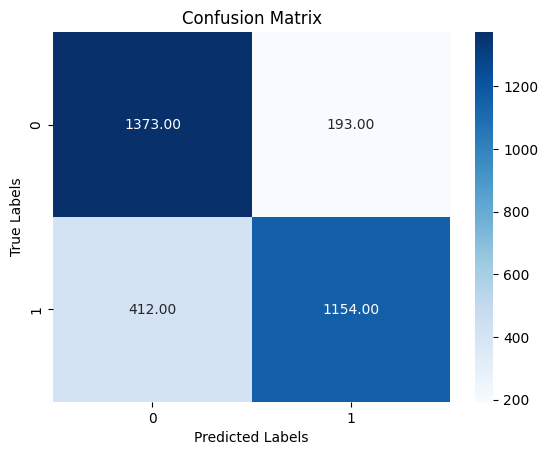

In [21]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify if a given text is **toxic** or not. Use TF-IDF vectorization to convert text into numerical features and train a `MultinomialNB` model. If needed use `RandomUnderSampler()`. Compare the results with the transformer model.

In [22]:
# Write your code here. Add as many boxes as you need.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

In [23]:
df

,text,label
0,both sides need to calm the fuck down or we ar...,1
1,and what shit hole country might you be from,1
2,You make that with impunity and you may get so...,0
3,"Get more grip, please",0
4,anyone who doesn 't kiss the ayatollah must be...,0
...,...,...
995,"Hold your cheeks, thrusting at once, crying out",0
996,Who asks why muslims hate us,0
997,"i don 't care if i get downvoted , but Amanda ...",0
998,the fuck is wrong with the catholic clergy ?,1


In [24]:
X_train = df['text']
Y_train = df['label']

In [25]:
df_test = dataset["test"].to_pandas()
df_test

,text,label
0,this is a free country that protectsamendment ...,1
1,generous seperation packages my ass !,1
2,"obama has been a total failure , and now looks...",1
3,voting for her if the examiner and mitch the e...,1
4,the message is pbot doesnt give a shit about y...,1
...,...,...
3127,We already have a lot of indians coming here d...,0
3128,"If they used it, they are responsible for it, ...",0
3129,i don 't know why people are downvoting me .,0
3130,They mistreat you.,0


In [26]:
X_test = df_test['text']
Y_test = df_test['label']

In [27]:
model = make_pipeline_imb(TfidfVectorizer(), RandomUnderSampler(), MultinomialNB())
model.fit(X_train, Y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomundersampler', RandomUnderSampler()),
                ('multinomialnb', MultinomialNB())])

In [28]:
y_pred = model.predict(X_test)

In [29]:
print(classification_report_imbalanced(Y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.71      0.87      0.77      0.79      0.61      1566
          1       0.75      0.87      0.71      0.81      0.79      0.63      1566

avg / total       0.80      0.79      0.79      0.79      0.79      0.62      3132



# Невронска мрежа

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [33]:
dataset = load_dataset(
    'csv', 
    data_files={'train': 'data/train.tsv', 'test': 'data/test.tsv'},
    delimiter='\t'
)

In [34]:
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()
df_train

,text,label
0,both sides need to calm the fuck down or we ar...,1
1,and what shit hole country might you be from,1
2,You make that with impunity and you may get so...,0
3,"Get more grip, please",0
4,anyone who doesn 't kiss the ayatollah must be...,0
...,...,...
995,"Hold your cheeks, thrusting at once, crying out",0
996,Who asks why muslims hate us,0
997,"i don 't care if i get downvoted , but Amanda ...",0
998,the fuck is wrong with the catholic clergy ?,1


In [35]:
df_test

,text,label
0,this is a free country that protectsamendment ...,1
1,generous seperation packages my ass !,1
2,"obama has been a total failure , and now looks...",1
3,voting for her if the examiner and mitch the e...,1
4,the message is pbot doesnt give a shit about y...,1
...,...,...
3127,We already have a lot of indians coming here d...,0
3128,"If they used it, they are responsible for it, ...",0
3129,i don 't know why people are downvoting me .,0
3130,They mistreat you.,0


<Axes: xlabel='label'>

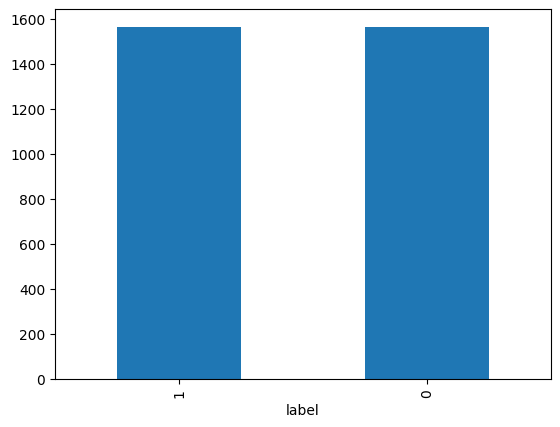

In [37]:
df_test["label"].value_counts().plot.bar()

<Axes: ylabel='Frequency'>

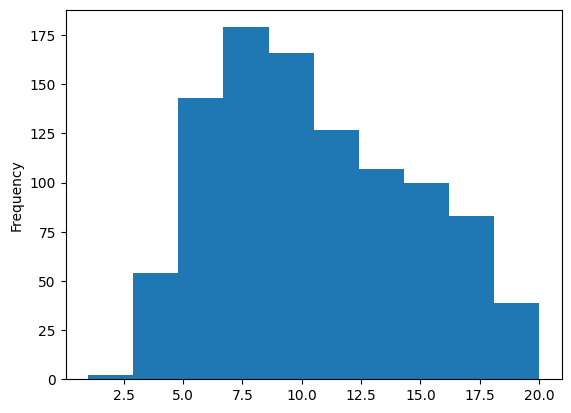

In [38]:
df_train["text"].str.split(" ").apply(len).plot.hist()

<Axes: ylabel='Frequency'>

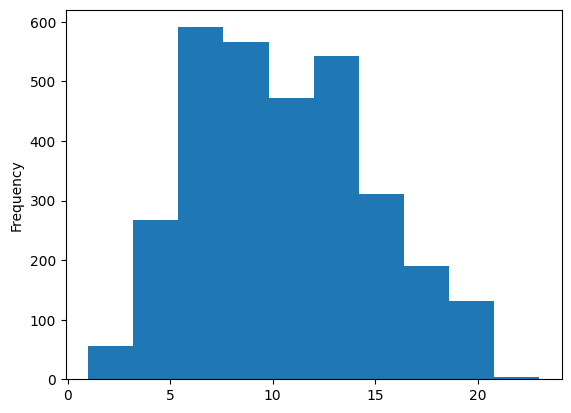

In [39]:
df_test["text"].str.split(" ").apply(len).plot.hist()

<Axes: >

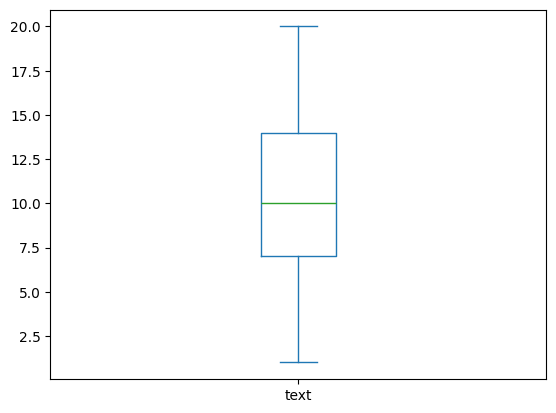

In [40]:
df_train["text"].str.split().apply(len).plot.box()

<Axes: >

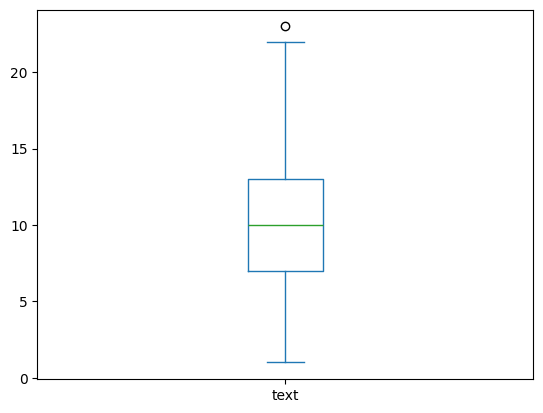

In [41]:
df_test["text"].str.split().apply(len).plot.box()

In [42]:
df_test = df_test[df_test["text"].str.split().apply(len) < 23].copy(deep=True)
df_test

,text,label
0,this is a free country that protectsamendment ...,1
1,generous seperation packages my ass !,1
2,"obama has been a total failure , and now looks...",1
3,voting for her if the examiner and mitch the e...,1
4,the message is pbot doesnt give a shit about y...,1
...,...,...
3127,We already have a lot of indians coming here d...,0
3128,"If they used it, they are responsible for it, ...",0
3129,i don 't know why people are downvoting me .,0
3130,They mistreat you.,0


<Axes: >

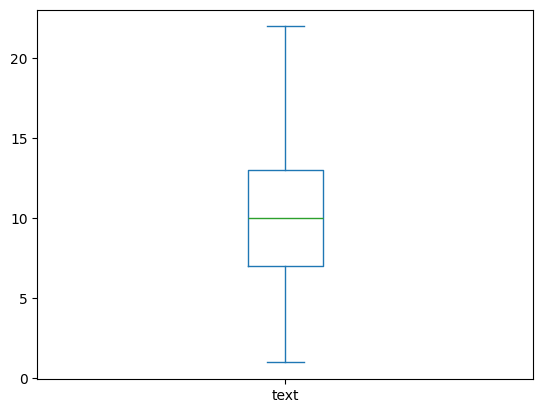

In [43]:
df_test["text"].str.split().apply(len).plot.box()

In [44]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [45]:
vocabulary = get_vocabulary(df_train["text"].tolist())

In [46]:
len(vocabulary)

2639

In [47]:
vocabulary = get_vocabulary(df_test["text"].tolist())
len(vocabulary)

4613

In [48]:
max_vocabulary_size = 2500

In [51]:
train_X = df_train["text"]
train_y = pd.get_dummies(df_train["label"])

In [52]:
test_X = df_test["text"]
test_y = pd.get_dummies(df_test["label"])

In [53]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

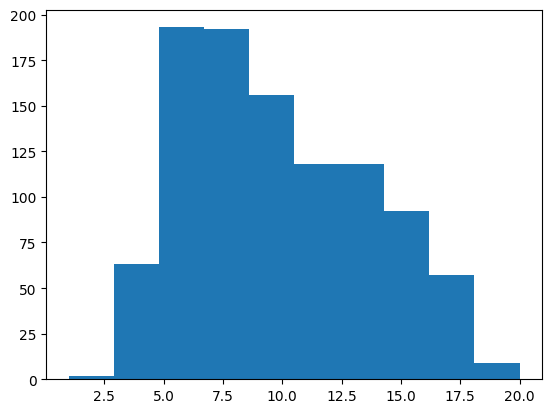

In [54]:
plt.hist([len(tokens) for tokens in train_X]);

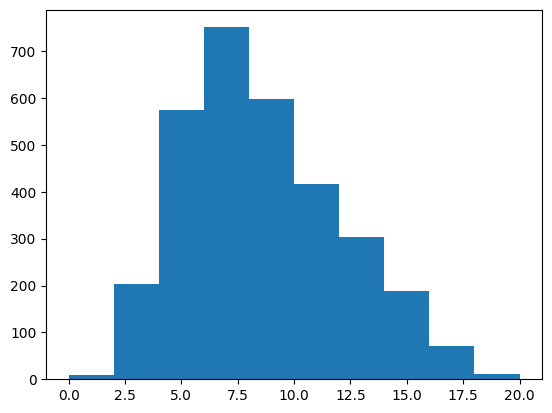

In [55]:
plt.hist([len(tokens) for tokens in test_X]);

In [56]:
maxlen = 16

In [57]:
train_X = sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = sequence.pad_sequences(test_X, maxlen=maxlen)

In [64]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=32),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(2, activation="sigmoid")
])

In [65]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [66]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=5)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - f1_score: 0.3411 - loss: 0.6932 - precision: 0.4912 - recall: 0.4030 - val_f1_score: 0.3302 - val_loss: 0.6925 - val_precision: 0.4895 - val_recall: 0.4650
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - f1_score: 0.5275 - loss: 0.6899 - precision: 0.6012 - recall: 0.5336 - val_f1_score: 0.5778 - val_loss: 0.6875 - val_precision: 0.5870 - val_recall: 0.5400
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - f1_score: 0.6495 - loss: 0.6762 - precision: 0.6696 - recall: 0.6280 - val_f1_score: 0.6162 - val_loss: 0.6612 - val_precision: 0.6158 - val_recall: 0.5850
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - f1_score: 0.7246 - loss: 0.6069 - precision: 0.7344 - recall: 0.7075 - val_f1_score: 0.7193 - val_loss: 0.5402 - val_precision: 0.7245 - val_recall: 0.7100
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - f1_score: 0.8916 - loss: 0.3648 - precision: 0.9002 - recall: 0.8723 - val_f1_score: 0.8350 - val_loss: 0.4009 - v

In [67]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 16, 32)              │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 16, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 8, 16)               │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 4, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 321,176 (1.23 MB)

 Trainable params: 107,058 (418.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 214,118 (836.40 KB)

<Axes: >

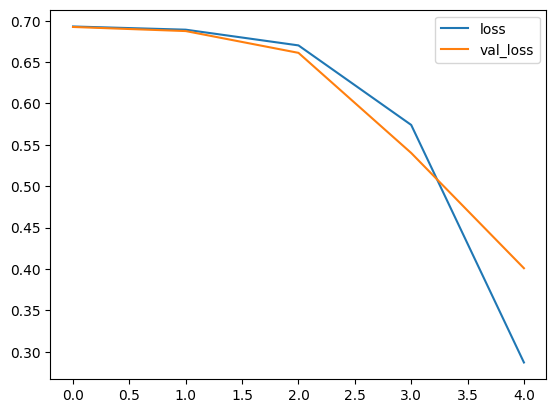

In [68]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [69]:
preds = model.predict(test_X)

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [70]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

In [71]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1565
           1       0.90      0.73      0.81      1566

    accuracy                           0.83      3131
   macro avg       0.84      0.83      0.83      3131
weighted avg       0.84      0.83      0.83      3131



Text(0.5, 1.0, 'Confusion Matrix')

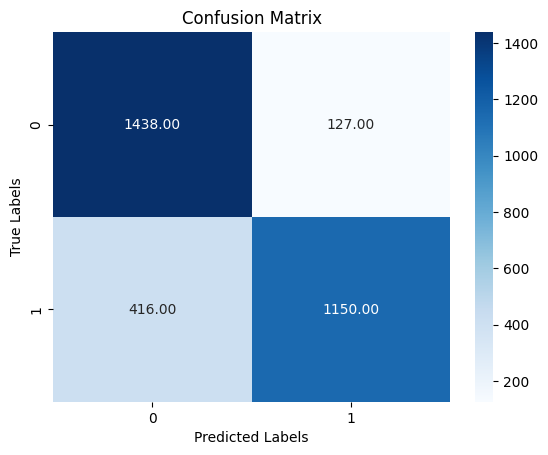

In [72]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")